# Assignment 4: RANSAC and Panorama Stitching

In [101]:
import numpy as np
import cv2
import math
import random
import sys
import pickle as pkl
import os.path as op
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
random.seed(1)

**Utility functions - assignment code below**

In [69]:
def MatchRANSAC(image1, image2, ratio_thres, orient_agreement, scale_agreement):
    """
    Read two images and their associated SIFT keypoints and descriptors.
    Find matches between images based on acos distance.
    Filter a subset of matches using RANSAC
    Display the final matches.
    HINT: See main_match.py on how to use this function.
    """
    im1, keypoints1, descriptors1 = ReadKeys(image1)
    im2, keypoints2, descriptors2 = ReadKeys(image2)

    keypoints1 = np.stack(keypoints1, axis=0)
    keypoints2 = np.stack(keypoints2, axis=0)
    matched_pairs = FindBestMatchesRANSAC(
        keypoints1, keypoints2,
        descriptors1, descriptors2,
        ratio_thres, orient_agreement, scale_agreement)
    matched_pairs = [
        [keypoints1[i], keypoints2[j]] for (i, j) in matched_pairs]
    assert len(matched_pairs) > 0, "No match received"
    im3 = DisplayMatches(im1, im2, matched_pairs)
    return im3


def Match(image1, image2, ratio_thres):
    """
    Read two images and their associated SIFT keypoints and descriptors.
    Find matches between images based on acos distance.
    Display the final matches.
    HINT: See main_match.py on how to use this function.
    """
    im1, keypoints1, descriptors1 = ReadKeys(image1)
    im2, keypoints2, descriptors2 = ReadKeys(image2)

    matched_pairs = FindBestMatches(
        descriptors1, descriptors2, ratio_thres)
    matched_pairs = [
        [keypoints1[i], keypoints2[j]] for (i, j) in matched_pairs]
    assert len(matched_pairs) > 0, "No match received"
    im3 = DisplayMatches(im1, im2, matched_pairs)
    return im3


def FindBestMatchesRANSAC(
        keypoints1, keypoints2,
        descriptors1, descriptors2, threshold,
        orient_agreement, scale_agreement):
    """
    Note: you do not need to change this function.
    However, we recommend you to study this function carefully
    to understand how each component interacts with each other.

    This function find the best matches between two images using RANSAC.
    Inputs:
        keypoints1, 2: keypoints from image 1 and image 2
            stored in np.array with shape (num_pts, 4)
            each row: row, col, scale, orientation
        descriptors1, 2: a K-by-128 array, where each row gives a descriptor
        for one of the K keypoints.  The descriptor is a 1D array of 128
        values with unit length.
        threshold: the threshold for the ratio test of "the distance to the nearest"
                   divided by "the distance to the second nearest neighbour".
                   pseudocode-wise: dist[best_idx]/dist[second_idx] <= threshold
        orient_agreement: in degrees, say 30 degrees.
        scale_agreement: in floating points, say 0.5
    Outputs:
        matched_pairs_ransac: a list in the form [(i, j)] where i and j means
        descriptors1[i] is matched with descriptors2[j].
    Detailed instructions are on the assignment website
    """
    orient_agreement = float(orient_agreement)
    assert isinstance(keypoints1, np.ndarray)
    assert isinstance(keypoints2, np.ndarray)
    assert isinstance(descriptors1, np.ndarray)
    assert isinstance(descriptors2, np.ndarray)
    assert isinstance(threshold, float)
    assert isinstance(orient_agreement, float)
    assert isinstance(scale_agreement, float)
    matched_pairs = FindBestMatches(
        descriptors1, descriptors2, threshold)
    matched_pairs_ransac = RANSACFilter(
        matched_pairs, keypoints1, keypoints2,
        orient_agreement, scale_agreement)
    return matched_pairs_ransac


def ReadKeys(image):
    """Input an image and its associated SIFT keypoints.

    The argument image is the image file name (without an extension).
    The image is read from the PGM format file image.pgm and the
    keypoints are read from the file image.key.

    ReadKeys returns the following 3 arguments:

    image: the image (in PIL 'RGB' format)

    keypoints: K-by-4 array, in which each row has the 4 values specifying
    a keypoint (row, column, scale, orientation).  The orientation
    is in the range [-PI, PI] radians.

    descriptors: a K-by-128 array, where each row gives a descriptor
    for one of the K keypoints.  The descriptor is a 1D array of 128
    values with unit length.
    """
    im = Image.open(image+'.pgm').convert('RGB')
    keypoints = []
    descriptors = []
    first = True
    with open(image+'.key','r') as f:
        reader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC,skipinitialspace = True)
        descriptor = []
        for row in reader:
            if len(row) == 2:
                assert first, "Invalid keypoint file header."
                assert row[1] == 128, "Invalid keypoint descriptor length in header (should be 128)."
                count = row[0]
                first = False
            if len(row) == 4:
                keypoints.append(np.array(row))
            if len(row) == 20:
                descriptor += row
            if len(row) == 8:
                descriptor += row
                assert len(descriptor) == 128, "Keypoint descriptor length invalid (should be 128)."
                #normalize the key to unit length
                descriptor = np.array(descriptor)
                descriptor = descriptor / math.sqrt(np.sum(np.power(descriptor,2)))
                descriptors.append(descriptor)
                descriptor = []
    assert len(keypoints) == count, "Incorrect total number of keypoints read."
    print("Number of keypoints read:", int(count))
    descriptors = np.stack(descriptors, axis=0)
    return [im,keypoints,descriptors]


def AppendImages(im1, im2):
    """Create a new image that appends two images side-by-side.

    The arguments, im1 and im2, are PIL images of type RGB
    """
    im1cols, im1rows = im1.size
    im2cols, im2rows = im2.size
    im3 = Image.new('RGB', (im1cols+im2cols, max(im1rows,im2rows)))
    im3.paste(im1,(0,0))
    im3.paste(im2,(im1cols,0))
    return im3


def DisplayMatches(im1, im2, matched_pairs):
    """Display matches on a new image with the two input images placed side by side.

    Arguments:
     im1           1st image (in PIL 'RGB' format)
     im2           2nd image (in PIL 'RGB' format)
     matched_pairs list of matching keypoints, im1 to im2

    Displays and returns a newly created image (in PIL 'RGB' format)
    """
    im3 = AppendImages(im1,im2)
    offset = im1.size[0]
    draw = ImageDraw.Draw(im3)
    for match in matched_pairs:
        draw.line((match[0][1], match[0][0], offset+match[1][1], match[1][0]),fill="red",width=2)
    return im3


def ReadData(fname):
    """
    Given the fname, return the image, keypoints, and descriptors.
    Note: the fname should be a path of the image, but with no extensions.
    For example, '/my/path/ubc.png' should be '/my/path/ubc'
    """
    with open(fname + '.pkl', 'rb') as f:
        data = pkl.load(f)
    im = Image.open(fname + '.png').convert('RGB')
    keypoints = data['keypoints']
    descriptors = data['descriptors']
    return [im, keypoints, descriptors]


def FindBestMatchesXY(im_src_path, im_ref_path, ratio_thres):
    """
    This function takes two image paths, fetch the corresponding keypoints
    of the two image paths, find the best matches between keypoints
    and return the keypoint correspondances in xy coordinates.
    Inputs:
        im_src_path: the path of the source image.
        im_ref_path: the path of the image considered as the reference frame.
        ratio_thres: threshold for ratio test.
    Outputs:
        xy_src: numpy array, (matches, 2), xy coordinates of keypoints in source.
        xy_ref: numpy array, (matches, 2), xy coordinates of keypoints in ref.
    """
    assert isinstance(im_src_path, str)
    assert isinstance(im_ref_path, str)
    assert isinstance(ratio_thres, float)
    _, keypoints1, descriptors1 = ReadData(im_src_path)
    _, keypoints2, descriptors2 = ReadData(im_ref_path)
    matches = list(FindBestMatches(descriptors1, descriptors2, ratio_thres))
    matches = [(keypoints1[i1], keypoints2[i2]) for (i1, i2) in matches]

    # Extract the xy of the matches
    yx_src, yx_ref = zip(*[(match[0][:2], match[1][:2]) for match in matches])
    xy_src = np.array(yx_src)[:, [1, 0]]  # yx to xy
    xy_ref = np.array(yx_ref)[:, [1, 0]]
    return xy_src, xy_ref


def PrepareData(image_list, ratio_thres):
    """
    This function takes in a list of image paths of interests;
    Extracts the keypoints correspondance between the reference image and all other images.
    The first image on the image_list is the reference image.
    Note: there is no RANSAC performed.
    Inputs:
        image_list: a list of paths to the images (with no extensions)
        ratio_thres: the threshold for doing the ratio test of keypoint correspondance.
    Outputs:
        xy_src_list: numpy array, (num_matches, 2)
        xy_ref_list: numpy array, (num_matches, 2)
        im_list: a list of np.array, where each np.array is an image.
    """
    assert isinstance(image_list, list)
    assert len(image_list) > 1, "Need at leat two images to do stiching"
    assert isinstance(image_list[0], str)
    assert isinstance(ratio_thres, float)
    assert ratio_thres >= 0.0
    assert ratio_thres <= 1.0

    xy_src_list = []
    xy_ref_list = []
    ref_image = image_list[0]
    image_list = image_list[1:]
    for src_image in image_list:
        xy_src, xy_ref = FindBestMatchesXY(
            src_image, ref_image, ratio_thres)
        if xy_src.shape[0] >= 4:
            xy_src_list.append(xy_src)
            xy_ref_list.append(xy_ref)

    im_ref, _, _ = ReadData(ref_image)
    im_list = [np.array(im_ref)] + [
        np.array(ReadData(img)[0]) for img in image_list]
    return xy_src_list, xy_ref_list, im_list


def MergeWarppedImages(canvas_height, canvas_width, warp_list):
    """
    Wrap a list of images in the reference frame into one canvas.
    Note:
        each image is a numpy array of shape (canvas_height, canvas_width, 3)
        The first image in the warp_list is the reference image
    """
    assert isinstance(canvas_height, int)
    assert isinstance(canvas_width, int)
    assert isinstance(warp_list, list)

    canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

    im_ref = warp_list[0]  # reference image in reference frame
    assert im_ref.dtype == np.uint8
    canvas[:im_ref.shape[0], :im_ref.shape[1]] = im_ref
    alpha = 0.5
    for wrap in warp_list[1:]:
        assert isinstance(wrap, np.ndarray)
        assert wrap.shape == canvas.shape
        assert wrap.dtype == np.uint8
        mask_wrap = Image.fromarray(wrap).convert('L')
        mask_wrap = np.array(mask_wrap) > 0

        mask_canvas = Image.fromarray(canvas).convert('L')
        mask_canvas = np.array(mask_canvas) > 0

        mask_intersect = np.logical_and(mask_canvas, mask_wrap)

        # blend in intersected area
        canvas[mask_intersect] = (
                alpha*canvas[mask_intersect] +
                (1-alpha)*wrap[mask_intersect]).astype(np.uint8)
        canvas[mask_intersect] = (
                alpha*canvas[mask_intersect] +
                (1-alpha)*wrap[mask_intersect]).astype(np.uint8)

        # copy in non-interected area
        mask_empty = np.logical_not(mask_intersect)
        canvas[mask_empty] += wrap[mask_empty]
    return canvas


def ProjectImages(
        xy_src_list, xy_ref_list, im_list,
        canvas_height, canvas_width, num_iter, tol):
    """
    This function takes in a list of images, and the points correspondance between
    the reference image and other images; computes the homography from every source
    image to the reference image using RANSAC; warp each source image to the reference
    image frame using each homography computed.
    Inputs:
        xy_src_list: a list of np array, each element is keypoint correspondance
                     between a source image to the reference image, in xy coordinates.
        xy_ref_list: a list of np array, each element is keypoint correspondance
                     between a source image to the reference image, in xy coordinates.
        im_list: all images in np.array form, the firs element is the reference image.
        canvas_height, canvas_width: the dimension of the canvas to copy the warps over.
        num_iter: number of RANSAC iterations in RANSACHomography
        tol: the Euclidean tolerance for keypoints matching projection.
    Outputs:
        A list of images in np.array form after they have been projected to
        the reference frame.
    """
    assert isinstance(xy_src_list, list)
    assert isinstance(xy_ref_list, list)
    assert isinstance(im_list, list)
    assert isinstance(canvas_height, int)
    assert isinstance(canvas_width, int)
    assert isinstance(num_iter, int)
    assert isinstance(tol, (int, float))
    assert len(xy_src_list) == len(xy_ref_list)
    assert len(xy_src_list) + 1 == len(im_list), \
        "Num of source images + 1 == num of all images"

    homo_list = []
    for xy_src, xy_ref in zip(xy_src_list, xy_ref_list):
        h = RANSACHomography(xy_src, xy_ref, num_iter, tol)
        homo_list.append(h)
    warp_list = [im_list[0]]
    im_list = im_list[1:]
    assert len(im_list) == len(homo_list)
    for im, h in zip(im_list, homo_list):
        result = cv2.warpPerspective(im, h, (canvas_width, canvas_height))
        warp_list.append(result)
    return warp_list


def VisualizePointProj(xy_src, xy_ref, xy_proj, im_src, im_ref):
    assert isinstance(xy_src, np.ndarray)
    assert isinstance(xy_ref, np.ndarray)
    assert isinstance(xy_proj, np.ndarray)
    assert isinstance(im_src, np.ndarray)
    assert isinstance(im_ref, np.ndarray)
    assert xy_src.shape == xy_ref.shape
    assert xy_src.shape == xy_proj.shape

    fig, axes = plt.subplots(
        1, 2, figsize=(30, 30), gridspec_kw={'width_ratios': [1, 2]})
    for xy_a, xy_b in zip(xy_proj, xy_ref):
        x1, y1 = xy_a
        x2, y2 = xy_b
        axes[1].plot([x1, x2],[y1, y2], 'w-', linewidth=2)

    axes[0].imshow(im_src)
    axes[0].scatter(xy_src[:, 0], xy_src[:, 1], c='#fafba4', s=100, marker='.')
    axes[0].title.set_text('Source Image')

    axes[1].imshow(im_ref)
    axes[1].scatter(xy_proj[:, 0], xy_proj[:, 1], c='#fafba4', s=100, marker='.')
    axes[1].scatter(xy_ref[:, 0], xy_ref[:, 1], c='#d63447', s=100, marker='.')
    axes[1].title.set_text('Reference Image')
    fig.show()
    input('Press any key to exit the program')

## Part 1: SIFT Keypoint Matching
This sample program loads two images and their invariant keypoints and then draws 5 lines between randomly selected keypoints to show how matches can be displayed. Your task is to improve this program so that it identifies and displays correct matches by comparing the keypoint descriptor vectors. Note: Your program should find all possible matches, not just 5 as shown in this sample.

### Question 1.3: Vanilla Keypoint Matching
A threshold of 0.6 was used to give mostly good matches for "scene" and "book". From the image, you can see that there are some outlier matches, where keypoints of the book matches to the box of "bastoncini" and the chair. However, most of the matches are good. When the threshold is decreased to 0.5, there are not as many matches. When the threshold is increased to 0.7, there are too many outliers.

Number of keypoints read: 694
Number of keypoints read: 490


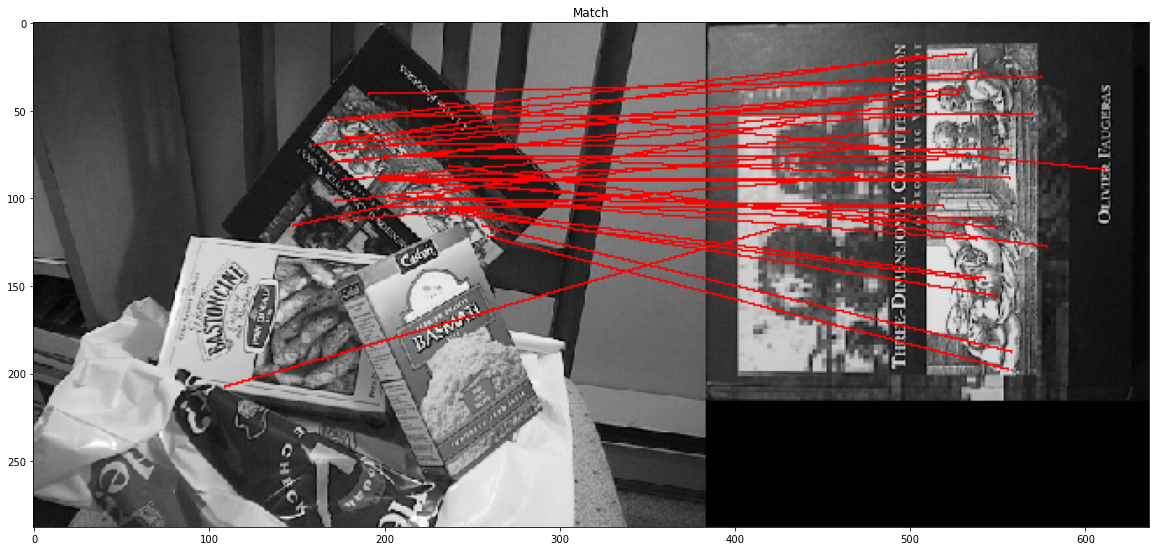

In [64]:
def FindBestMatches(descriptors1, descriptors2, threshold):
    """
    This function takes in descriptors of image 1 and image 2,
    and find matches between them. See assignment instructions for details.
    Inputs:
        descriptors: a K-by-128 array, where each row gives a descriptor
        for one of the K keypoints.  The descriptor is a 1D array of 128
        values with unit length.
        threshold: the threshold for the ratio test of "the distance to the nearest"
                   divided by "the distance to the second nearest neighbour".
                   pseudocode-wise: dist[best_idx]/dist[second_idx] <= threshold
    Outputs:
        matched_pairs: a list in the form [(i, j)] where i and j means
                       descriptors1[i] is matched with descriptors2[j].
    """
    assert isinstance(descriptors1, np.ndarray)
    assert isinstance(descriptors2, np.ndarray)
    assert isinstance(threshold, float)
    k1,d1 = descriptors1.shape
    k2,d2 = descriptors2.shape
    # calculate similarities between descriptors 1 and 2
    angles = np.empty((k1,k2))
    for i,d1 in enumerate(descriptors1):
        for j,d2 in enumerate(descriptors2): 
            angles[i,j] = math.acos(np.dot(d1,d2))
    
    # eliminate false matches by comparing best match to second best
    matched_pairs = []
    for i in range(k1):
        top_two = np.argsort(angles[i,:])[:2]
        # match is only selected if ratio is below given threshold
        if angles[i,top_two[0]]/angles[i,top_two[1]] <= threshold:
            matched_pairs.append([i,top_two[0]])
    return matched_pairs

# Test run matching with no ransac
plt.figure(figsize=(20, 20))
# im = Match('./data/scene', './data/basmati', ratio_thres=0.7)
im = Match('./data/scene', './data/book', ratio_thres=0.6)
plt.title('Match')
plt.imshow(im)

### Question 1.4: Keypoint Matching with RANSAC Filtering
By using RANSAC filtering, the matching threshold can be increased from 0.6 to 0.8 while maintaining approximately the same number of matches. This is because consistency checking in the RANSAC filter narrows down the matches to contain more relevent matchings by limiting the results to be in a certain orientation and scale range. An orientation agreement of around 15 degrees and scale agreement of around 0.75 were found to filter the matches to contain the best results. Additionally, the matching threshold was set to 0.8 because an increase to 0.9 resulted in a majority of matches to be incorrect. 0.8 was found to give the most numerous matches without sacrificing too much on accuracy. 

Number of keypoints read: 1766
Number of keypoints read: 849
Number of keypoints read: 1766
Number of keypoints read: 849


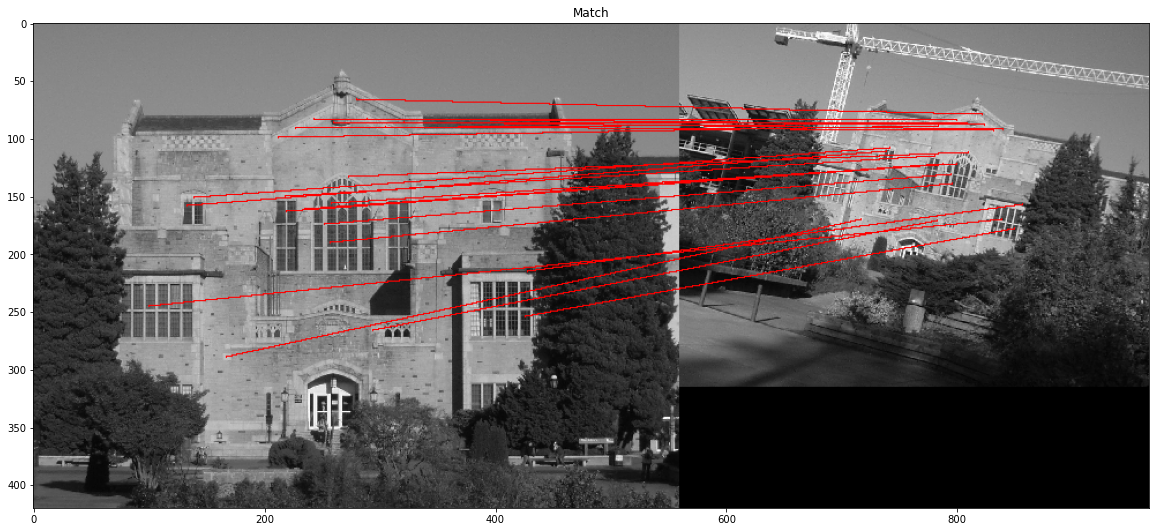

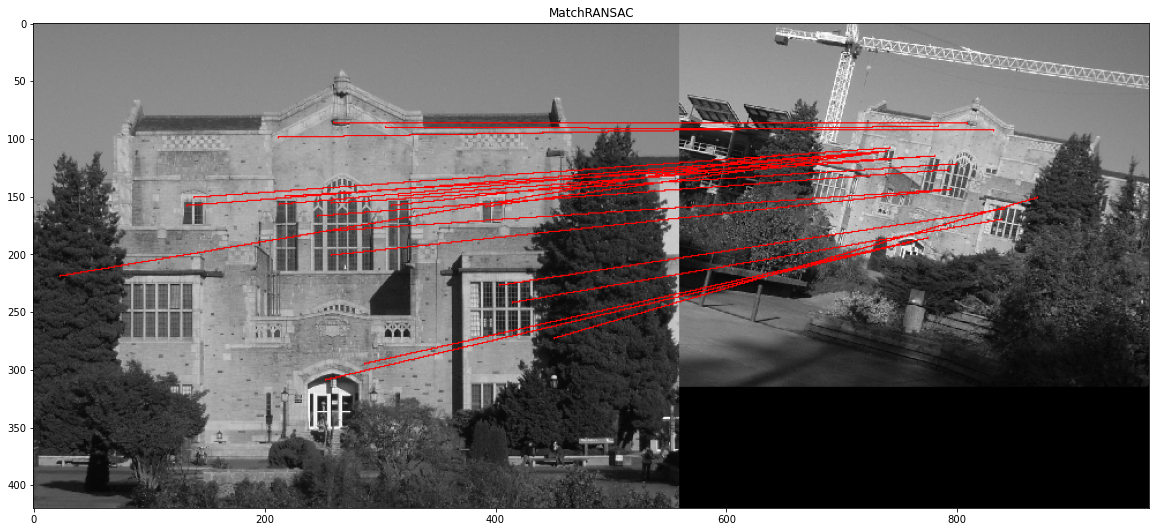

In [99]:
def RANSACFilter(matched_pairs, keypoints1, keypoints2, orient_agreement, scale_agreement):
    """
    This function takes in `matched_pairs`, a list of matches in indices
    and return a subset of the pairs using RANSAC.
    Inputs:
        matched_pairs: a list of tuples [(i, j)],
            indicating keypoints1[i] is matched
            with keypoints2[j]
        keypoints1, 2: keypoints from image 1 and image 2
            stored in np.array with shape (num_pts, 4)
            each row: row, col, scale, orientation
        *_agreement: thresholds for defining inliers, floats
    Output:
        largest_set: the largest consensus set in [(i, j)] format
    """
    assert isinstance(matched_pairs, list)
    assert isinstance(keypoints1, np.ndarray)
    assert isinstance(keypoints2, np.ndarray)
    assert isinstance(orient_agreement, float)
    assert isinstance(scale_agreement, float)

    largest_set = []
    # for each RANSAC iteration, select one match at random
    for iteration in range(10):
        p1,p2 = random.choice(matched_pairs)
        subset = []
        
        # check all other matches for consistency with p1 and p2
        for i,j in matched_pairs:
            
            # check for change of orientation
            o1 = math.degrees(keypoints1[p1,2]) - math.degrees(keypoints2[p2,2])
            o2 = math.degrees(keypoints1[i,2]) - math.degrees(keypoints2[j,2])
            orient_consistent = (abs(o1-o2) < orient_agreement)
            
            # check for change of scale
            s1 = keypoints2[p2,3]/keypoints1[p1,3]
            s2 = keypoints2[j,3]/keypoints1[i,3]
            scale_change = s1*scale_agreement
            scale_consistent = (s1 - scale_change <= s2 <= s1 + scale_change)
            
            # add to subset of matches if both orientation/scale are consistent
            if orient_consistent and scale_consistent:
                subset.append([i,j])
        
        # update largest_set if new subset is larger
        if len(subset) > len(largest_set):
            largest_set = subset
            
    assert isinstance(largest_set, list)
    return largest_set


# Test run matching with no ransac
plt.figure(figsize=(20, 20))
im = Match('./data/library', './data/library2', ratio_thres=0.6)
plt.title('Match')
plt.imshow(im)

# Test run matching with ransac
plt.figure(figsize=(20, 20))
im = MatchRANSAC('./data/library', './data/library2', ratio_thres=0.8, orient_agreement=15, scale_agreement=0.75)
plt.title('MatchRANSAC')
plt.imshow(im)

## Part 2: Panorama Stitching

Contents of test_pano.py

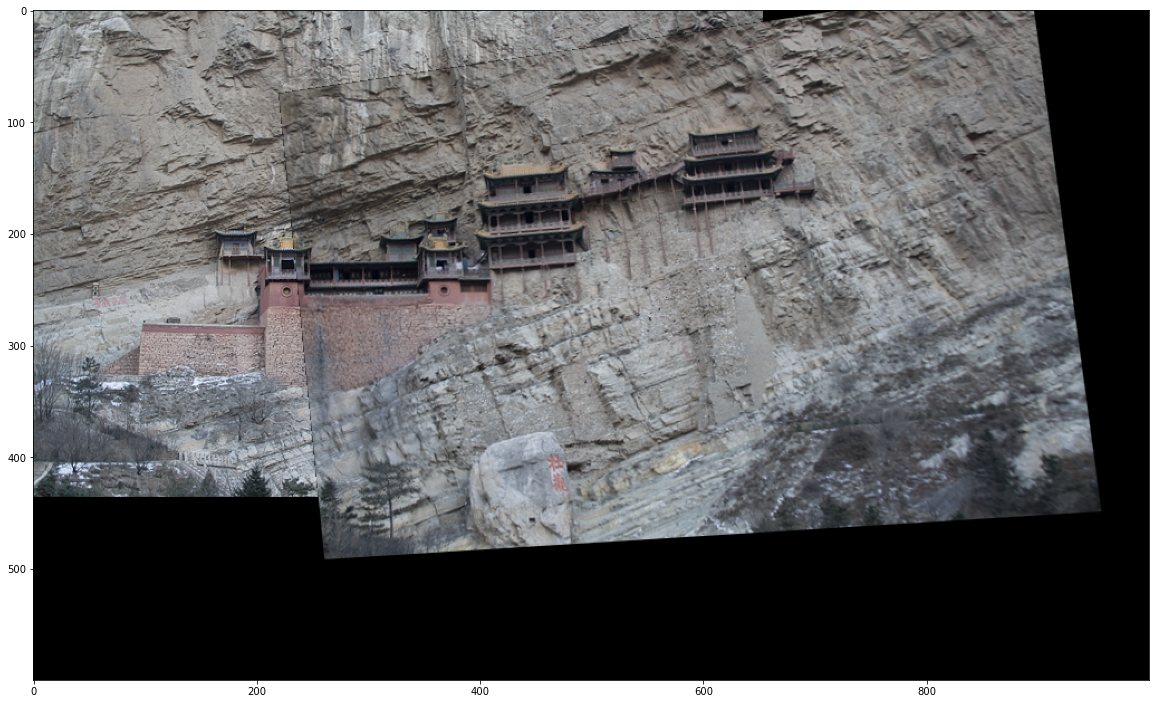

In [100]:
path = './data/'
image_list = ['Hanging1', 'Hanging2']
image_list = [op.join(path, im) for im in image_list]
# the dimension of the canvas (numpy array)
# to which we are copying images.
canvas_width = 1000
canvas_height = 600

# some precomputed data for sanity check
with open('./data/test.pkl', 'rb') as f:
    test_dict = pkl.load(f)
h_gt = test_dict['h']  # the homograph matrix we computed

# matches between the source and the refence image
xy_src = test_dict['xy_src']  # (match, 2)
xy_ref = test_dict['xy_ref']  # (match, 2)

# image_list should store both the reference and the source images
ref_image = image_list[0]  # first element is the reference image
source_image = image_list[1]

# compute the homography matrix to transform the source to the reference
h, _ = cv2.findHomography(xy_src, xy_ref)

# The current computed value should equal to our precomputed one
norm_diff = ((h-h_gt)**2).sum()
assert norm_diff < 1e-7, 'The computed homography matrix should equal to the given one.'

# read the two images as numpy arrays
im_src = np.array(ReadData(source_image)[0])
im_ref = np.array(ReadData(ref_image)[0])

# project source image to the reference image using the homography matrix
# the size of canvas is specified to store all images after projections.
im_src_warp = cv2.warpPerspective(im_src, h, (canvas_width, canvas_height))

# warp_list should contain all images, where the first
# element is the reference image
warp_list = [im_ref, im_src_warp]
result = MergeWarppedImages(canvas_height, canvas_width, warp_list)

# plot the result of the warping
plt.figure(figsize=(20, 20))
plt.imshow(result)
plt.show()

### Question 2.3: Keypoint Projections

In [102]:
def KeypointProjection(xy_points, h):
    """
    This function projects a list of points in the source image to the
    reference image using a homography matrix `h`.
    Inputs:
        xy_points: numpy array, (num_points, 2)
        h: numpy array, (3, 3), the homography matrix
    Output:
        xy_points_out: numpy array, (num_points, 2), input points in
        the reference frame.
    """
    assert isinstance(xy_points, np.ndarray)
    assert isinstance(h, np.ndarray)
    assert xy_points.shape[1] == 2
    assert h.shape == (3, 3)

    # START

    # END
    return xy_points_out


with open('./data/test.pkl', 'rb') as f:
    test_dict = pkl.load(f)

# visualize 30 random matches
num_pts = 30
idx = np.random.permutation(test_dict['xy_src'].shape[0])[:num_pts]
xy_src = test_dict['xy_src'][idx]
xy_ref = test_dict['xy_ref'][idx]
h = test_dict['h']

# project the src keypoints to the reference frame using homography
xy_proj = KeypointProjection(xy_src, h)

# visualize the results
im_ref = np.array(Image.open('./data/Hanging1.png'))
im_src = np.array(Image.open('./data/Hanging2.png'))
VisualizePointProj(xy_src, xy_ref, xy_proj, im_src, im_ref)

NameError: name 'xy_points_out' is not defined

### Question 2.4: RANSAC Homography

In [37]:
def RANSACHomography(xy_src, xy_ref, num_iter, tol):
    """
    Given matches of keyponit xy coordinates, perform RANSAC to obtain
    the homography matrix. At each iteration, this function randomly
    choose 4 matches from xy_src and xy_ref.  Compute the homography matrix
    using the 4 matches.  Project all source "xy_src" keypoints to the
    reference image.  Check how many projected keyponits are within a `tol`
    radius to the coresponding xy_ref points (a.k.a. inliers).  During the
    iterations, you should keep track of the iteration that yields the largest
    inlier set. After the iterations, you should use the biggest inlier set to
    compute the final homography matrix.
    Inputs:
        xy_src: a numpy array of xy coordinates, (num_matches, 2)
        xy_ref: a numpy array of xy coordinates, (num_matches, 2)
        num_iter: number of RANSAC iterations.
        tol: float
    Outputs:
        h: The final homography matrix.
    """
    assert isinstance(xy_src, np.ndarray)
    assert isinstance(xy_ref, np.ndarray)
    assert xy_src.shape == xy_ref.shape
    assert xy_src.shape[1] == 2
    assert isinstance(num_iter, int)
    assert isinstance(tol, (int, float))
    tol = tol*1.0

    # START



    # END
    assert isinstance(h, np.ndarray)
    assert h.shape == (3, 3)
    return h


def create_pano(
        image_list, ratio_thres,
        canvas_height, canvas_width,
        num_iter, tol, figsize=(20, 20)):
    """
    This function creates a panorama using a list of images.
    Inputs:
        image_list: a list of str, the path to each image (without file extensions).
        ratio_thres: the ratio test threshold in `FindBestMatches`
        canvas_height, canvas_width: The dimension of the canvas
        num_iter: num of iterations of performing RANSAC to find the homography matrix.
        tol: tolerance for keypoint projection
    """
    # Get the matches from `FindBestMatches`
    # xy_src_list: np.array, (matches, 2) in xy format
    # xy_ref_list: np.array, (matches, 2) in xy format
    # im_list: a list of images in np.array
    xy_src_list, xy_ref_list, im_list = PrepareData(
        image_list, ratio_thres)

    # Use the matches to estimate a homography matrix to the ref image frame
    # for each source image. Then project each source image to the reference
    # frame using the homography matrix.
    wrap_list = ProjectImages(
        xy_src_list, xy_ref_list, im_list,
        canvas_height, canvas_width, num_iter, tol)

    # Merge the projected images above
    # Note: the first element is the reference image in warp_list
    result = MergeWarppedImages(
        canvas_height, canvas_width, wrap_list)

    # show the final panorama
    plt.figure(figsize=figsize)
    plt.imshow(result)
    plt.show()

In [ ]:
path = './data/'

canvas_height = 600
canvas_width = 1000
image_list = ['Rainier1', 'Rainier2', 'Rainier3','Rainier4','Rainier5','Rainier6']

num_iter = 50
tol = 10
ratio_thres = 0.9
image_list = [op.join(path, im) for im in image_list]
create_pano(image_list, ratio_thres, canvas_height, canvas_width,
            num_iter, tol, figsize=(20, 20))